In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import scipy
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def calcRSRS(df_price, N):
    '''
    INPUT：
    df_price: pandas DataFrame，the daily freq stock price dataframe
        df_price["high"]: the high price of the stock in that day
        df_price["low"]: the low price of the stock in that day
    N: int，the N parameter in model.
    M: int，the M parameter in model.

    OUTPUT：
    RSRS: list[float]，RSRS data
    '''

    _h = (df_price["high"] - df_price["high"].mean()) / df_price["high"].std()
    _l = (df_price["low"] - df_price["low"].mean()) / df_price["low"].std()

    _N = N

    RSRS = []

    for i in range(len(_h))[_N:]:
        data_high = _h.iloc[i - _N + 1: i + 1]
        data_low = _l.iloc[i - _N + 1: i + 1]
        
        _X_ols = sm.add_constant(data_low)
        model = sm.OLS(data_high, _X_ols)
        results = model.fit()
        RSRS.append(results.params.low)

    return RSRS

In [3]:
# RSRS Index Sigma Approach
def calc_beta_r2(highs, lows):
    
    xx = sm.add_constant(lows)  # add a constant for X
    model = sm.OLS(highs, xx).fit()  
    beta = model.params[1]  # model.params.low
    r2 = model.rsquared
    
    return beta, r2

def calcRSRS_sigma(df_price, N, M):
    '''
    INPUT：
    df_price: pandas DataFrame，the daily freq stock price dataframe
        df_price["high"]: the high price of the stock in that day
        df_price["low"]: the low price of the stock in that day
    N: int，the N parameter in model.
    M: int，the M parameter in model.

    OUTPUT：
    RSRS: list[float]，RSRS data
    '''
    # Intermediate Variables
    RSRS = []
    beta_weight = []
    r2_weight = []
    
    # Store data
    _h = df_price.high.values
    _l = df_price.low.values
    
    # Compute and store the list of beta and r2
    for i in range(0, len(_h) - N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        
        beta, r2 = calc_beta_r2(highs, lows)
        
        beta_weight.append(beta)
        r2_weight.append(r2)
        
    # Compute the RSRS index    
    for i in range(0, len(_h)- N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        
        beta, r2 = calc_beta_r2(highs, lows)
        
        beta_weight.append(beta)
        r2_weight.append(r2)        
        
    # Take the time series of beta in the previous M days and calculate the z_score standard score      
        section = beta_weight[-M:]
        mu = np.mean(section)
        sigma = np.std(section)
        z_score = (section[-1] - mu) / sigma
        
        
        rsrs = z_score * r2
        
        RSRS.append(rsrs)
        
        
    return RSRS

In [4]:
# Maximize Drawback Rate
def maxDrawbackRate(prices) -> float:
    '''
    INPUT：
    prices: np.array object. I'm not sure list and tuple will work or not.

    OUTPUT：
    rt: float，the max drawback rate for given data.
    '''
    prices = [-p for p in prices]
    inf = int(2 << 10)
    minprice = inf
    maxprofit = 0
    for price in prices:
        maxprofit = max(price - minprice, maxprofit)
        minprice = min(price, minprice)
    return maxprofit / minprice

In [5]:
# tushare is a Chinese stock market data API. 
# It is free to download shares' daily data in Chinese Market.
# I hope this API works well. 
# If anything wrong with this package and you cannot get the data,
# please contact us.

import tushare as ts
pro = ts.pro_api('6278bfee192fcc3496a2789689930a63f3dd2027811b101933ee2064')

In [6]:
# # df_ori = pro.daily(ts_code='000100.SZ', start_date='20100101', end_date='20201231')
# df_ori = pro.daily(ts_code='000001.SZ', start_date='20000101', end_date='20201231')

# df_ori.to_csv("000100.csv")

In [7]:
# RSRS Statistics Display
df_ori = pro.daily(ts_code='000001.SZ', start_date='20000101', end_date='20201231')
# df_ori = pro.daily(ts_code='000100.SZ', start_date='20100101', end_date='20201231')

df_ori = sqldf(
    """
    SELECT
        *
    FROM
        df_ori
    ORDER BY
        trade_date ASC
    """
)

# df_ori["mean_price"] = (df_ori["high"] + df_ori["low"] + df_ori["open"] + df_ori["close"]) / 4


rsrs = calcRSRS(df_ori, N=18)
rsrs = np.array(rsrs)

In [8]:
print("Mean:", rsrs.mean())
print("Std:", rsrs.std())
print("Skew:", scipy.stats.skew(rsrs))
print("Kurt:", scipy.stats.kurtosis(rsrs))

Mean: 0.926401514814105
Std: 0.16102539334387272
Skew: 0.3324572378614215
Kurt: 3.8173792492545875


<AxesSubplot:ylabel='Count'>

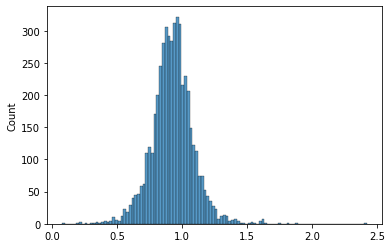

In [9]:
sns.histplot(rsrs)

<AxesSubplot:xlabel='trade_date'>

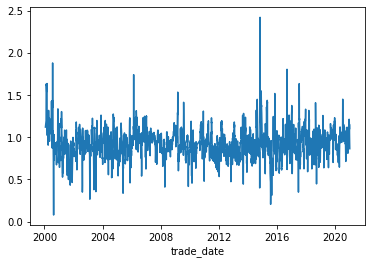

In [10]:
x = pd.to_datetime(df_ori.trade_date)[18:]
sns.lineplot(x=x, y=rsrs)

<AxesSubplot:xlabel='trade_date', ylabel='open'>

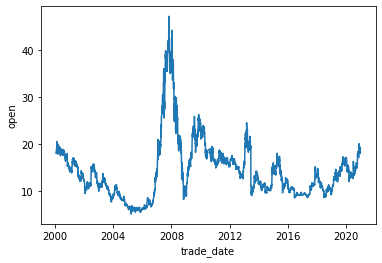

In [11]:
x = pd.to_datetime(df_ori.trade_date)[18:]
# sns.lineplot(x=x, y=df_ori["mean_price"][18:])
sns.lineplot(x=x, y=df_ori["open"][18:])

In [12]:
np.corrcoef(rsrs, df_ori["change"][18:])

array([[1.        , 0.08614031],
       [0.08614031, 1.        ]])

In [13]:
# RSRS Selection: using 000001.sh as example
# We set the threshold for longing and shorting.
# Long: When RSRS > 1
# Short: When RSRS < 0.8

thre_long = 1
thre_short = 0.8

In [14]:
_is_hold = False
virtual_initial_cash = 1000000
virtual_cash = virtual_initial_cash
virtual_position = 0
virtual_value = virtual_initial_cash + 0
# Explanation: value = cash + stock = cash + position * price

# base_position = virtual_initial_cash / df_ori["mean_price"][18]
base_position = virtual_initial_cash / df_ori["open"][18]

# base: simply buy and hold the stock.

ct_long = 0
ct_short = 0


_value_list = []
_base_value = []

for i in range(len(rsrs)):
#     _p = df_ori["mean_price"][18 + i]
    _p = df_ori["open"][18 + i]
    
    if rsrs[i] >= thre_long and _is_hold == False:
        _is_hold = True
        ct_long += 1
        
        virtual_position = 100 * int(virtual_cash / (_p * 100))
        virtual_cash -= (virtual_position * _p) 
        
        
    if rsrs[i] <= thre_short and _is_hold:
        _is_hold = False
        ct_short += 1
        
        virtual_cash += (virtual_position * _p)
        virtual_position = 0
        
        
    _today_value = virtual_cash + virtual_position * _p
    _value_list.append(_today_value)
    _base_value.append(base_position * _p)

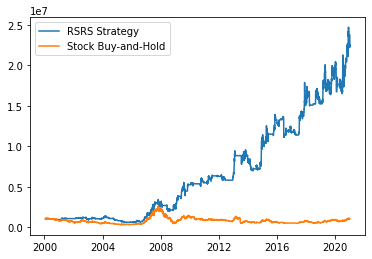

In [15]:
x = pd.to_datetime(df_ori.trade_date)[18:]
plt.plot(x, _value_list, label="RSRS Strategy")
plt.plot(x, _base_value, label="Stock Buy-and-Hold")
plt.legend(loc='upper left')

In [16]:
cur_value = _value_list[-1]

print("Recent value of portfolio:", cur_value)
print("Long time:", ct_long)
print("Short time:", ct_short)

Recent value of portfolio: 23733107.0
Long time: 92
Short time: 91


In [17]:
# annual return
_gain = (cur_value - virtual_value) / virtual_value
# annual_return = pow((1 + _gain), (1 / 11)) - 1
annual_return = pow((1 + _gain), (1 / 21)) - 1
annual_return

0.1627680128880158

In [18]:
_base_gain = (_base_value[-1] - virtual_initial_cash) / virtual_initial_cash
annual_return_base = pow((1 + _base_gain), (1 / 21)) - 1
# annual_return_base = pow((1 + _base_gain), (1 / 11)) - 1


# tracking error
track_err = np.array([(_value_list[i] - _base_value[i]) / virtual_initial_cash
                      for i in range(len(_value_list))]).std()
track_err

6.069533435238127

In [19]:
# information ratio
info_ratio = (annual_return - annual_return_base) / track_err
info_ratio

0.026306000717853176

In [20]:
maxDrawbackRate(_value_list)

-0.1606671767896756

In [21]:
# RSRS Selection: using 000001.sh as example
# We set the threshold for longing and shorting.
# Long: When RSRS > mean + std
# Short: When RSRS < mean - std

rsrs = []
rsrs = calcRSRS_sigma(df_ori, N=18, M=600)
rsrs = np.array(rsrs)

thre_long = rsrs.mean() + 1 * rsrs.std()
thre_short = rsrs.mean() - 1 * rsrs.std()

_is_hold = False
virtual_initial_cash = 1000000
virtual_cash = virtual_initial_cash
virtual_position = 0
virtual_value = virtual_initial_cash + 0

# base_position = virtual_initial_cash / df_ori["mean_price"][18]
base_position = virtual_initial_cash / df_ori["open"][18]

ct_long = 0
ct_short = 0


_value_list_v = []
_base_value = []

for i in range(len(rsrs)):
#     _p = df_ori["mean_price"][17 + i]
    _p = df_ori["open"][17 + i]
    
    if rsrs[i] >= thre_long and _is_hold == False:
        _is_hold = True
        ct_long += 1
        
        virtual_position = 100 * int(virtual_cash / (_p * 100))
        virtual_cash -= (virtual_position * _p) 
        
        
    if rsrs[i] <= thre_short and _is_hold:
        _is_hold = False
        ct_short += 1
        
        virtual_cash += (virtual_position * _p)
        virtual_position = 0
        
        
    _today_value = virtual_cash + virtual_position * _p
    _value_list_v.append(_today_value)
    _base_value.append(base_position * _p)

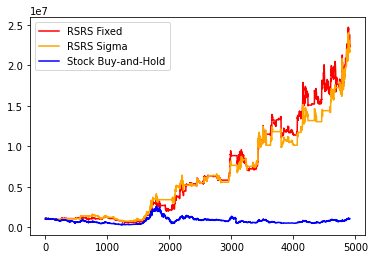

In [22]:
x = [i for i in range(len(_value_list))]
plt.plot(x, _value_list, color="red", label="RSRS Fixed")
plt.plot(x, _value_list_v[1:], color="orange", label="RSRS Sigma")
plt.plot(x, _base_value[1:], color="blue", label="Stock Buy-and-Hold")
plt.legend(loc='upper left')

In [23]:
_value_list = _value_list_v
cur_value = _value_list[-1]

print("Recent value of portfolio:", cur_value)
print("Long time:", ct_long)
print("Short time:", ct_short)

Recent value of portfolio: 23065175.0
Long time: 55
Short time: 55


In [24]:
maxDrawbackRate(_value_list)

-0.16091223786938835

In [25]:
# annual return
_gain = (cur_value - virtual_value) / virtual_value
# annual_return = pow((1 + _gain), (1 / 11)) - 1
annual_return = pow((1 + _gain), (1 / 21)) - 1

annual_return

0.16118843714311537

In [26]:
_base_gain = (_base_value[-1] - virtual_initial_cash) / virtual_initial_cash
# annual_return_base = pow((1 + _base_gain), (1 / 11)) - 1
annual_return_base = pow((1 + _base_gain), (1 / 21)) - 1

# tracking error
track_err = np.array([(_value_list[i] - _base_value[i]) / virtual_initial_cash
                      for i in range(len(_value_list))]).std()
track_err

5.310932744878423

In [28]:
# information ratio
info_ratio = (annual_return - annual_return_base) / track_err
info_ratio

0.02976606610429341

In [ ]:
# # RSRS Selection: Dynamic Threshold
# # We calculate the threshold everyday with the recent N = 18 days.

# # thre_long = rsrs.mean() + 1 * rsrs.std()
# # thre_short = rsrs.mean() - 1 * rsrs.std()


# thre_long = rsrs.mean() + 1 * rsrs.std()
# thre_short = rsrs.mean() - 1 * rsrs.std()

# _is_hold = False
# virtual_initial_cash = 10000
# virtual_cash = virtual_initial_cash
# virtual_position = 0
# virtual_value = virtual_initial_cash

# base_position = virtual_initial_cash / df_ori["mean_price"][18]

# ct_long = 0
# ct_short = 0


# _value_list = []
# _base_value = []

# for i in range(len(rsrs)):
#     _rs = rsrs[i: i + 18]
#     thre_long = _rs.mean() + 1 * _rs.std()
#     thre_short = _rs.mean() - 1 * _rs.std()
    
#     _p = df_ori["mean_price"][18 + i]
    
#     if rsrs[i] >= thre_long and _is_hold == False:
#         _is_hold = True
#         ct_long += 1
        
#         virtual_position = virtual_cash / _p
#         virtual_cash = 0
        
        
#     if rsrs[i] <= thre_short and _is_hold:
#         _is_hold = False
#         ct_short += 1
        
#         virtual_cash = virtual_position * _p 
#         virtual_position = 0
        
#     _today_value = virtual_cash + virtual_position * _p
    
    
#     _value_list.append(_today_value)
#     _base_value.append(base_position * _p)

In [ ]:
# x = [i for i in range(len(_value_list))]
# plt.plot(x, _value_list, label="RSRS Dynamic Strategy")
# plt.plot(x, _base_value, label="Stock Buy-and-Hold")
# plt.legend(loc='upper left')